<div style="text-align:center">
    <h1>
        REINFORCE
    </h1>
</div>

<br><br>

<div style="text-align:center">
In this notebook we are going to implement the Monte Carlo version of Policy Gradient methods. The REINFORCE algorithm uses the full return to update the policy:
</div>

\begin{equation}
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+1} + \cdots + \gamma^{T-t-1} R_{T}
\end{equation}


<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 10 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [ ]:
%%latex
$\textbf{Import the necessary Library}$

In [1]:
import os
import torch
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW

from utils import test_policy_network, seed_everything, plot_stats, plot_action_probs
from parallel_env import ParallelEnv, ParallelWrapper
import warnings
 
warnings.filterwarnings("ignore")

## Create and preprocess the environment

### Create the environment

In [2]:
#test_policy_network to test the effectiveness of the policy using NN
#ParallelEnv to create several copies of the same task so that the agent interact and learn from all of them at the same time

In [3]:
%%latex
$\textbf{Create the environment and display the observation and action spaces}$

<IPython.core.display.Latex object>

In [4]:
env = gym.make('CartPole-v0')

In [5]:
#number of dims and number of actions

dims = env.observation_space.shape[0]
actions = env.action_space.n

print(f"State dimensions: {dims}. Action: {actions}")
print(f"Sample state: {env.reset()}")   #[position of cart, velocity of cart, angle of pole, rotation rate of pole]

State dimensions: 4. Action: 2
Sample state: [-0.03666613 -0.00133848  0.007378   -0.02919273]


In [6]:
#we have two actions available: moving the car to the left or moving it to the right


### Action Space
    The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction
     of the fixed force the cart is pushed with.
    | Num | Action                 |
    |-----|------------------------|
    | 0   | Push cart to the left  |
    | 1   | Push cart to the right |
    
    **Note**: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle
     the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it
    ### Observation Space
    The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:
    | Num | Observation           | Min                 | Max               |
    |-----|-----------------------|---------------------|-------------------|
    | 0   | Cart Position         | -4.8                | 4.8               |
    | 1   | Cart Velocity         | -Inf                | Inf               |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
    | 3   | Pole Angular Velocity | -Inf                | Inf               | 

IndentationError: unexpected indent (248434255.py, line 5)

In [7]:
%%latex
$\textbf{Show the state of the task}$

<IPython.core.display.Latex object>

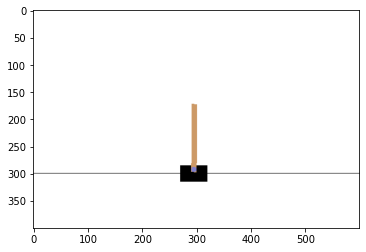

In [8]:
plt.imshow(env.render(mode='rgb_array'))

In [9]:
#we control the black car and we need to keep the pole upright
#create parallel env to allow the agent to sample experience and learn from all of them at the same time
#the number of env we can create depend on the number of CPU we have in our computer ie 8 core processors = 8 envs

#seed_everything make sure that everytime we run this notebook, we get the same result
#ParallelEnv to create isolate processes and inside each process, it create a copy of the env

### Parallelize the environment

In [10]:
%%latex
$\textbf{Parallel Learning: Parallelize the environment}$
Since we are using a single computer, the number of environment we can create depends on the number of CPU or 
core processors we have.In our case, we can create up to 8 environments. The module ParallelEnv we imported 
allows us to create isolate processes and inside each process, it creates a copy of the environment.

<IPython.core.display.Latex object>

In [11]:
num_envs = os.cpu_count()
num_envs

8

In [12]:
#num_envs = 4
def create_env(env_name, seed):
    env= gym.make(env_name)
    seed_everything(env, seed=seed) # to makse sure each time we run this notebook we get the same result
    return env

In [13]:
env_fns =[lambda: create_env('CartPole-v0', rank) for rank in range(num_envs)]
#[fn, fn, fn]
parallel_env = ParallelEnv(env_fns) 
parallel_env.reset()

array([[-0.0224773 ,  0.04186813, -0.01038048,  0.03759079],
       [-0.0224773 ,  0.04186813, -0.01038048,  0.03759079],
       [-0.0224773 ,  0.04186813, -0.01038048,  0.03759079],
       [-0.0224773 ,  0.04186813, -0.01038048,  0.03759079],
       [-0.0224773 ,  0.04186813, -0.01038048,  0.03759079],
       [-0.0224773 ,  0.04186813, -0.01038048,  0.03759079],
       [-0.0224773 ,  0.04186813, -0.01038048,  0.03759079],
       [-0.0224773 ,  0.04186813, -0.01038048,  0.03759079]],
      dtype=float32)

In [14]:
#size of the observations from the parallel env




In [15]:
# Each of the envs generate a state with 4 dims: [position of cart, velocity of cart, angle of pole, rotation rate of pole]
# Each state from the parallel environment will contain 8 rows of states

### Prepare the environment to work with PyTorch

In [16]:
%%latex
$\textbf{Prepare the environment to work with PyTorch using ParallelWrapper}$

<IPython.core.display.Latex object>

In [17]:
#prepare the parallel env to work with Pytorch library

class PreprocessEnv(ParallelWrapper): #This class will inherit from the ParallelWrapper
    
    def __init__(self, parallel_env):
        ParallelWrapper.__init__(self, parallel_env)
        
    #reset override
    def reset(self):
        state =  self.venv.reset() # reset the para env and fectching the initial observation
            # venv is the para env stored in ParallelWrapper
        return torch.from_numpy(state).float() #convert into numpy tensor
        
        
    #step_async will take care of executing the actions taken by the agent in each of the envs
    def step_async(self, actions):
#             [[3],
#             [2],
#             [1]] -> convert to [3, 2, 1] using squeeze() and numpy()
        actions = actions.squeeze().numpy() 
        self.venv.step_async(actions)
        
    #step_wait method will wait and bloack the execution until each of the env has processed the actions to collect 
    # the rewards archived, the next state and all the variables that the agent needs to work with
    def step_wait(self):
        next_state, reward, done, info  = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward =  torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1) #[False, True, False..], then conver into a col vector with unsqueeze(1)
        return next_state, reward, done, info


In [18]:
parallel_env = PreprocessEnv(parallel_env) #ready to work with Pytorch

In [19]:
%%latex
$\textbf{A look at the state, reward and done variables after being processed by our env wrapper}$

<IPython.core.display.Latex object>

In [20]:
state = parallel_env.reset()
#torch.zeros(num_envs, 1, dtype=torch.int32 = example of column vector of actions that the agent will take
_, reward, done, _ = parallel_env.step(torch.zeros(num_envs, 1, dtype=torch.int32))

print(f"State: {state}, Reward: {reward}, Done: {done}")

State: tensor([[-0.0008,  0.0129,  0.0031, -0.0229],
        [-0.0008,  0.0129,  0.0031, -0.0229],
        [-0.0008,  0.0129,  0.0031, -0.0229],
        [-0.0008,  0.0129,  0.0031, -0.0229],
        [-0.0008,  0.0129,  0.0031, -0.0229],
        [-0.0008,  0.0129,  0.0031, -0.0229],
        [-0.0008,  0.0129,  0.0031, -0.0229],
        [-0.0008,  0.0129,  0.0031, -0.0229]]), Reward: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]), Done: tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])


In [21]:
%%latex
$\textbf{A look at the state, reward and done variables after being processed by our env wrapper}$

#here the policy will be an object we obatin usng Sequential class of NN
#we take states as inputs and the NN will apply some operations we saw in ML class in NN to produce the outputs
#The output here is the vector with the probabilities of taking each of the actions


<IPython.core.display.Latex object>

### Create the policy $\pi(s)$ using NN 

In [22]:

policy = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64), #second layer
    nn.ReLU(),
    nn.Linear(64, actions), #[-Inf, +Inf]-
    nn.Softmax(dim=-1)) #[.3, .2, .5], softmax applied on the last dim(dim=-1)

# we choose 128 arbitraly to define the size of the first hidden layer, same as 64 for the second hidden layer
# ReLu breaks the linearity from the previous operation

### Plot action probabilities

In [23]:
%%latex
$\textbf{Plot action probabilities}$

<IPython.core.display.Latex object>

In [24]:
neutral_state = torch.zeros(4) #car at the center, [0, 0, 0, 0]
left_danger = torch.tensor([-2.3, 0., 0., 0.]) # car at the left edge of the horizontal axis
right_danger = torch.tensor([2.3, 0., 0., 0.])# car located on the right edge of the horizontal axis

#### Plot a neutral environment

In [25]:
%%latex
$$\textbf{Plot a neutral environment with NN initialized with random parameters}$$

NN initialized with random parameters, so the probs we wll see do not reflect the correct action at the beginning of the process
since random probabilities will be assigned.

<IPython.core.display.Latex object>

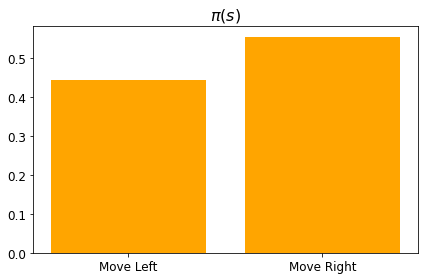

In [26]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])


In [27]:
# probability of moving right is slightly higher than the prob of moving left. both are quiet closed as they were generated
# by a NN with random parameters

#### Plot a state where the cart is too far left

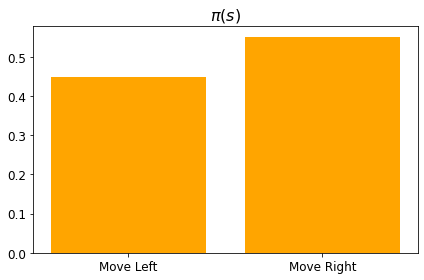

In [28]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far right

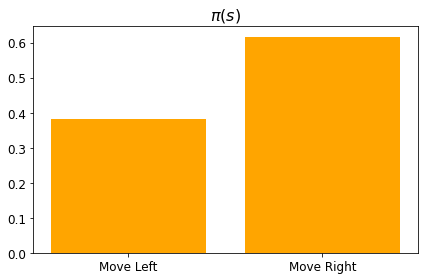

In [29]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

In [30]:
# they (actions) will still be closed to each other due to random probabilites assigned 

In [31]:
%%latex
$\textbf{Reinforce Algorithm}$

<IPython.core.display.Latex object>

## Implement the algorithm

</br></br>


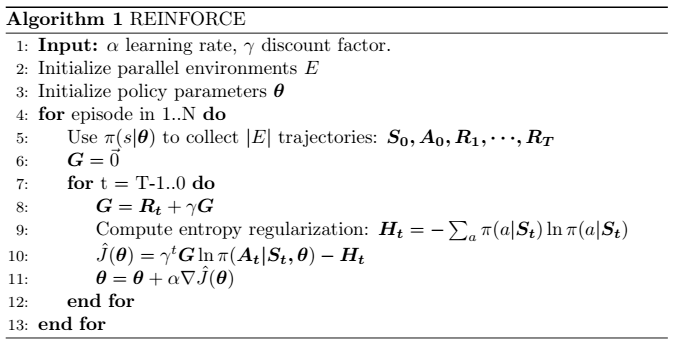

In [32]:
%%latex
$\textbf{Implementation of the Reinforce Algorithm}$

<IPython.core.display.Latex object>

In [33]:
def reinforce(policy, episodes, alpha=1e-4, gamma=.99):
    
    #AdamW is an improved version of SGD, used to update the parameters of the NN
    optim = AdamW(policy.parameters(), lr=alpha)
    
    #dictionary to store the stats of the execution of the algo
    stats = {'Loss':[], 'Returns':[]}
    
    #wrap tqdm to be able to see the execution of this loop. It tells us the iter already executed & the ones left
    for episode in tqdm(range(1, episodes + 1)):
        #use NN to face he env and collect sample of expiriences. We'll collect an episode for each env in the parallel env
        
        state = parallel_env.reset() #initialise the para env
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool) # done bacth, boolian value telling us if each of the env
               # in the para env has finished the episode or not
        
        transitions = [] # to store the state transition
        ep_return = torch.zeros((num_envs, 1)) #to keep track of the return obtained in each of individual episode that the 
               # agent is facing in each env of the para env
        
        #inner loop where will generate the trajectories of experience
        
        while not done_b.all():
            #multinomial(1) to pick a single action for each state
            #.detach() to make sure pytorch won't include these variable in the back propagate taht will use to update the NN 
            action = policy(state).multinomial(1).detach()
            next_state, reward, done, _ = parallel_env.step(action)
            transitions.append([state, action, ~done_b * reward]) # -done_b * reward to convert into zeros the reward corresp
               # to env whose episodes has already finished, ie envs whose done_b is True
                
            ep_return += reward #update the return
            done_b |= done # update env whose ep has finished after this move
            state =  next_state
        
        #Improve the policy
        G = torch.zeros((num_envs, 1)) # 1-single col as the return if a single value
        
        for t, (state_t, action_t, reward_t) in reversed(list(enumerate(transitions))):
            G =  reward_t + gamma * G
            probs_t = policy(state_t)
            log_probs_t = torch.log(probs_t + 1e-6) #avoid computing log of zero by addin 1e-6
            action_log_probs_t =  log_probs_t.gather(1, action_t) #only for actions taken at moment t 
    
            entropy_t = -torch.sum(probs_t * log_probs_t, dim=-1, keepdim=True ) #dim=-1 so that the sum is applied independently
             # and we get the value of entropy for each individual vector of probs
            #keepdim=True so the dim of the tensor remains unchanged
            
            gamma_t = gamma ** t
            
            #policy performance
            pg_loss_t = -gamma_t * action_log_probs_t * G # - sign because AdamW can only perform gradient descent ie 
                #in opposite direction of max growth or gradient ascent
            total_loss_t = (pg_loss_t - 0.01 * entropy_t).mean()
            
            # As always when we compute the NN
            policy.zero_grad()
            total_loss_t.backward() # to launch the back propagation to compute the gradient of the loss function
                # with respect to each of the parameters of the NN
            
            #call AdamW to update the parameters
            optim.step()
            
        #store the execution statistics in the stats dictionary    
        stats['Loss'].append(total_loss_t.item()) #item() convert pytorch tensor into scalar no
        stats['Returns'].append(ep_return.mean().item())
        
    return stats
            

In [34]:
parallel_env.reset()
stats = reinforce(policy, 200)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:15<00:00,  1.47it/s]


## Show results

### Show execution stats

In [ ]:
%%latex
$\textbf{Loss and Retrun functions for 2 parallel learning environments }$

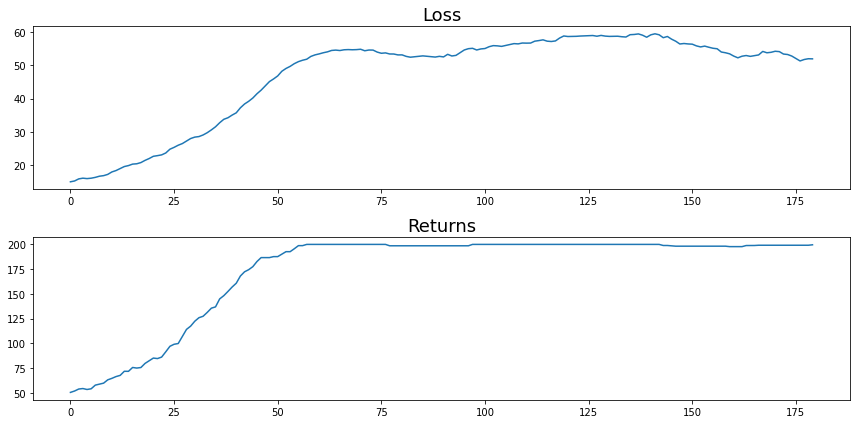

In [35]:
plot_stats(stats)

In [ ]:
# we see that in the first 60 episodes, the retuns have been improving until reaching their maximum value (200).
# And the policy performance has followed a similar trajectory. 

### Plot action probabilities

#### Plot a neutral environment

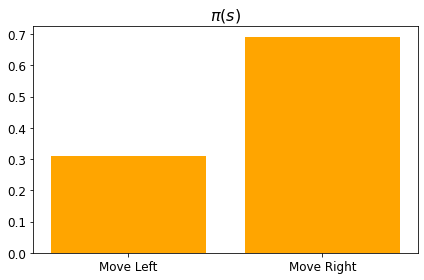

In [36]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

In [37]:
#The policy assigns a slightly higher probability of moving left, but in general, both actions have a very similar probability.

#### Plot a state where the cart is too far left

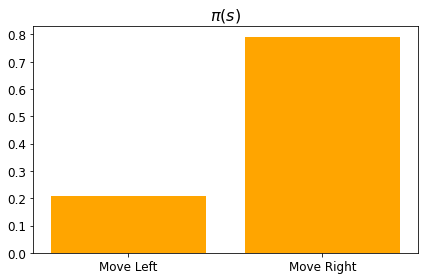

In [38]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

In [39]:
# When there's danger. To the left. Our policy assigns a much higher probability for us to move, right?
# And when the danger is on the right, the policy prescribes. Moving to the left. 
#Note that the probability of moving to the right is not zero.
#That is the effect of using the entropy as a means of regularizing the learning process.

#Since we are trying to maximize the entropy, we are favoring that the policy never gets to pick an action 
#100 percent of the time. And that allows us to keep the exploration of the accent for a longer time.

#### Plot a state where the cart is too far right

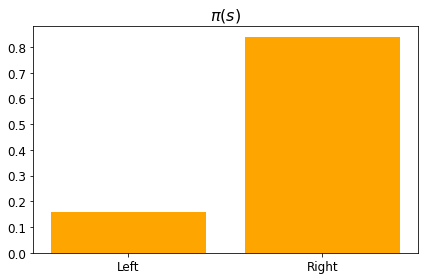

In [40]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

### Test the resulting agent

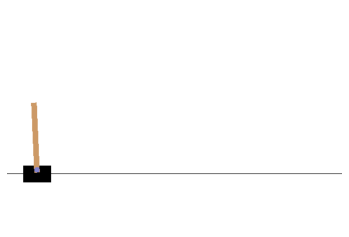

In [41]:
test_policy_network(env, policy, episodes=5)

In [ ]:
# We can see that the policy is capable of solving the task, it is capable of keeping the pole upright.

## Resources

[[1] Reinforcement Learning: An Introduction. Ch.13](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)